# COMP S493F Lab 12

In [ ]:
#| include: false
%env TF_CPP_MIN_LOG_LEVEL=2
# import tensorflow as tf
# tf.config.experimental.enable_op_determinism()

env: TF_CPP_MIN_LOG_LEVEL=2


In this lesson, you'll work on:

- generative adversarial networks, and
- creating images of digits and fashions.

### Student name: *Lo TSz Kin*


# Creating images of digits

A *generative adversarial network*, or *GAN*, is a generative deep-learning model for creating new data instances that are similar to those in a training dataset. A GAN consists of an adversarial pair of two models:

- A *generator* generates data instances (also called examples, samples, observations) that appear as if they come from the training dataset.

- A *discriminator* predicts whether an instance is real or fake, i.e. whether it comes from the training dataset or is generated by the generator.

If a generator can fool a smart discriminator, the generated instances are as good as real ones!

In this section, we implement a GAN for creating images of digits based on the MNIST digit dataset. To begin with, here are a few import statements.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

The following `load_and_prep_mnist()` function loads the prepares the MNIST digit dataset, and returns the training features `X_train`. It has two parameters: `digits` for specifying a subset of digits to return (e.g. `"1357"`; the default `"all"` meaning to return all 10 digits), and `ratio` for the ratio of the examples to return.

In [ ]:
def load_and_prep_digits(digits="all", ratio=1.0):
    keras.utils.set_random_seed(42)
    (X_train, y_train), _ = mnist.load_data()
    if digits != "all":
        digits = [int(d) for d in digits]
        mask = np.isin(y_train, digits)
        X_train = X_train[mask]
    if ratio < 1:
        sz_train = int(len(X_train) * ratio)
        X_train = X_train[:sz_train]
    X_train = X_train.astype(float) / 255
    X_train = X_train.reshape(-1, 28, 28, 1)
    return X_train

This function creates the generator model. Note the use of the leaky ReLU activation, which is generally recommended for GANs.

In [2]:
def create_generator():
    model = keras.Sequential([
        layers.Dense(49),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Reshape(target_shape=(7, 7, 1)),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, kernel_size=(5, 5), padding="same",
                      activation="sigmoid")
    ])
    return model

This function creates the discriminator model.

In [3]:
def create_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")
    model.trainable = False
    return model

This function creates the whole GAN model from the generator and the discriminator.

In [4]:
def create_gan(generator, discriminator):
    model = keras.Sequential([generator, discriminator])
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return model

This function generates random noise for use as inputs to the generator.

In [5]:
def generate_sample_inputs(n_samples):
    inputs = np.random.normal(0, 1, size=(n_samples, 7*7))
    return inputs

This function invokes the generator to generate a number of data instances, or samples.

In [6]:
def generate_samples(generator, n_samples):
    inputs = generate_sample_inputs(n_samples)
    samples = generator.predict(inputs, verbose=0)
    return samples

This function displays generated samples.

In [7]:
import matplotlib.pyplot as plt

def plot_samples(samples):
    plt.figure(figsize=(15,3))
    n = len(samples)
    for i in range(n):
        plt.subplot(1, n, (i+1))
        plt.imshow(samples[i].reshape(28, 28), cmap="gray_r")
        plt.axis("off")
    plt.show()

This function trains the discriminator. It uses both real examples from the training dataset and fake examples generated by the generator.

In [17]:
def train_discriminator(generator, discriminator, X_train_batch, batch_size):
    X_real = X_train_batch
    y_real = np.ones(batch_size)
    X_fake = generate_samples(generator, batch_size)
    y_fake = np.zeros(batch_size)
    discriminator.trainable = True
    loss = discriminator.train_on_batch(X_real, y_real)
    loss += discriminator.train_on_batch(X_fake, y_fake)
    discriminator.trainable = False
    return loss / 2

This function trains the generator using the whole GAN. Note that the labels `y` are set to 1's, i.e. "real". This is because the aim of training the generator is to fool the discriminator, i.e. to let it predict "real" for fake examples.

In [8]:
def train_generator(generator, gan, batch_size):
    X = generate_sample_inputs(batch_size)
    y = np.ones(batch_size)
    loss = gan.train_on_batch(X, y)
    return loss

This function trains the whole GAN, by training the discriminator and the generator alternately.

In [9]:
import math, time

def train_gan(generator, discriminator, gan, X_train, epochs=100,
              batch_size=512):
    n_batches = math.ceil(len(X_train) / batch_size)
    history = {"gen_loss": [], "dsc_loss": [], "message": [], "samples": []}
    start_time = time.time()
    for i in range(epochs):
        gen_loss = dsc_loss = 0
        for j in range(n_batches):
            start = j * batch_size
            end = min((j+1) * batch_size, len(X_train))
            X_train_batch = X_train[start:end]
            dsc_loss += train_discriminator(generator, discriminator,
                                            X_train_batch, end-start)
            gen_loss += train_generator(generator, gan, end-start)
        update_history(history, start_time, i, epochs, gen_loss / n_batches,
                       dsc_loss / n_batches, generator)
    return history

This function updates the training history when the GAN is being trained.

In [10]:
NUM_REPORTS = 10  # message and samples

def update_history(history, start_time, i, epochs, gen_loss, dsc_loss,
                   generator):
    history["gen_loss"].append(gen_loss)
    history["dsc_loss"].append(dsc_loss)
    if (i + 1) % (epochs // NUM_REPORTS) == 0:
        elapsed = time.time() - start_time
        message = f"Epoch {i+1}/{epochs}, time elapsed: {elapsed:.1f}s" + \
                  f", gen_loss: {gen_loss:.2f}, dsc_loss: {dsc_loss:.2f}"
        print(message)
        samples = generate_samples(generator, 10)
        plot_samples(samples)
        history["message"].append(message)
        history["samples"].append(samples)

This function plots the training history.

In [11]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.plot(history["dsc_loss"], label="discriminative loss")
    plt.plot(history["gen_loss"], label="generative loss")
    plt.legend()
    plt.show()

This code puts everything together to build a GAN for creating images of the digit "3".

11490434/11490434 [==============================] - 0s 0us/step
Epoch 10/100, time elapsed: 51.5s, gen_loss: 0.01, dsc_loss: 0.00


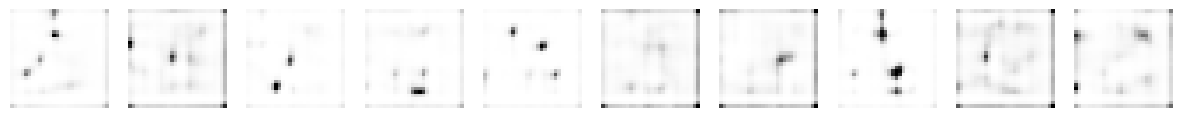

Epoch 20/100, time elapsed: 77.9s, gen_loss: 1.70, dsc_loss: 0.20


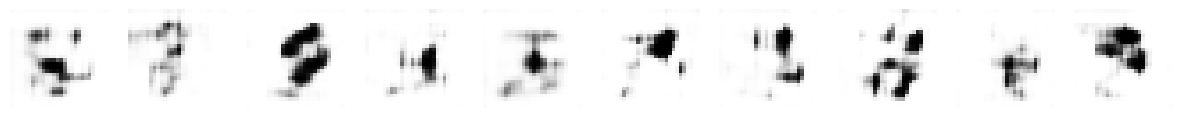

Epoch 30/100, time elapsed: 103.7s, gen_loss: 1.71, dsc_loss: 0.43


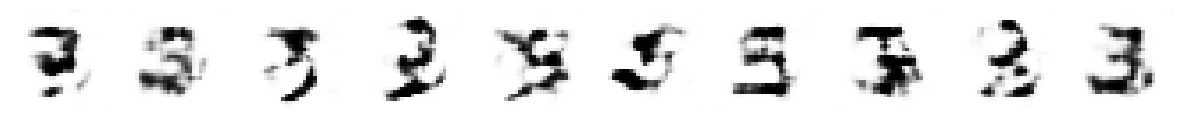

Epoch 40/100, time elapsed: 130.3s, gen_loss: 1.60, dsc_loss: 0.57


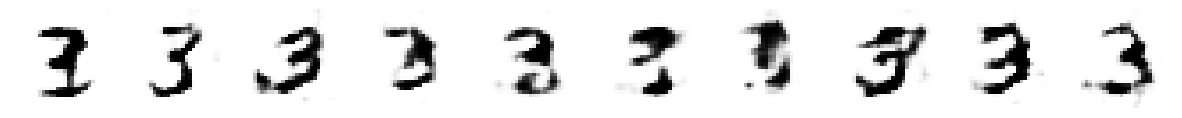

Epoch 50/100, time elapsed: 156.2s, gen_loss: 1.23, dsc_loss: 0.65


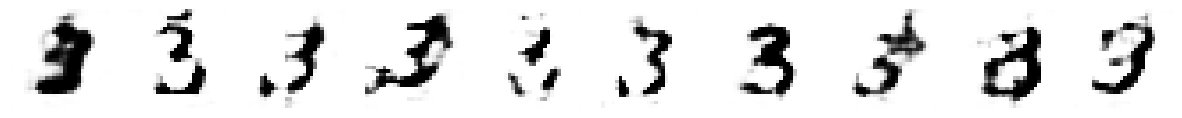

Epoch 60/100, time elapsed: 183.2s, gen_loss: 1.02, dsc_loss: 0.67


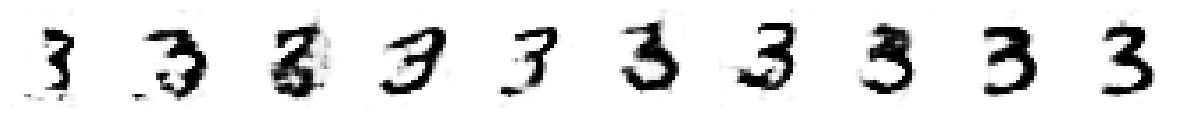

Epoch 70/100, time elapsed: 210.9s, gen_loss: 1.00, dsc_loss: 0.66


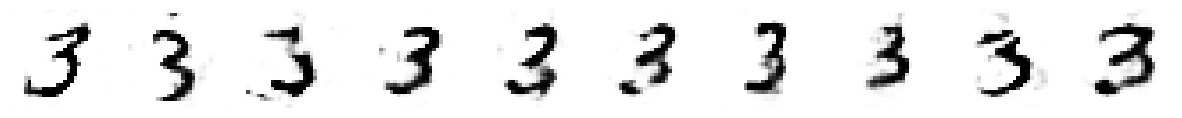

Epoch 80/100, time elapsed: 238.6s, gen_loss: 0.94, dsc_loss: 0.67


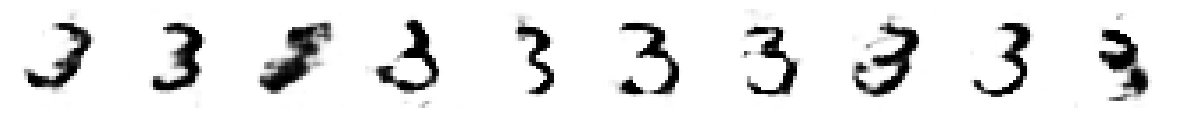

Epoch 90/100, time elapsed: 264.2s, gen_loss: 0.93, dsc_loss: 0.67


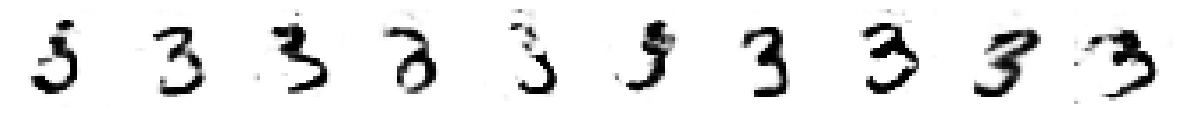

Epoch 100/100, time elapsed: 290.7s, gen_loss: 0.96, dsc_loss: 0.66


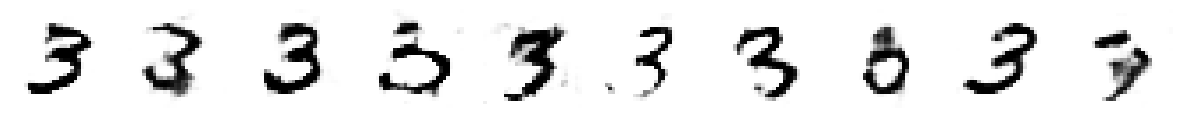

In [ ]:
X_train = load_and_prep_digits("3")
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)
history = train_gan(generator, discriminator, gan, X_train)

Sample images are generated using the trained GAN as follows.

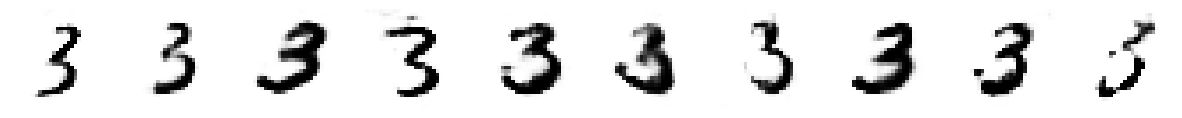

In [ ]:
samples = generate_samples(generator, 10)
plot_samples(samples)

The training history is plotted next.

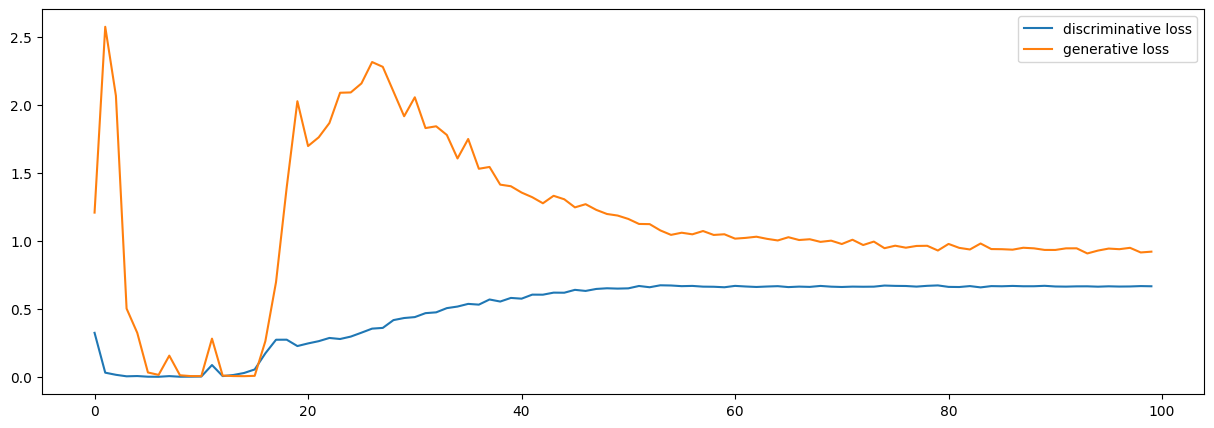

In [ ]:
plot_history(history)

# Practice - Question 1 of 2

## Q1a

Build a GAN for creating images of two (or more!) digits of your choice. Create sample images using the trained GAN, and plot the training history.

Epoch 10/100, time elapsed: 61.2s, gen_loss: 1.09, dsc_loss: 0.37


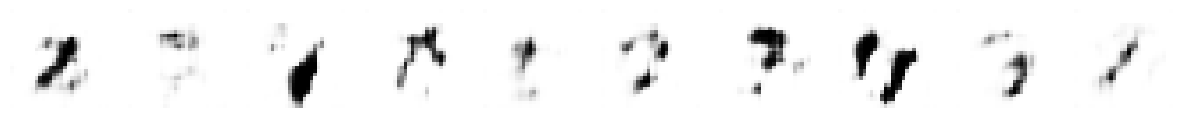

Epoch 20/100, time elapsed: 132.6s, gen_loss: 1.18, dsc_loss: 0.63


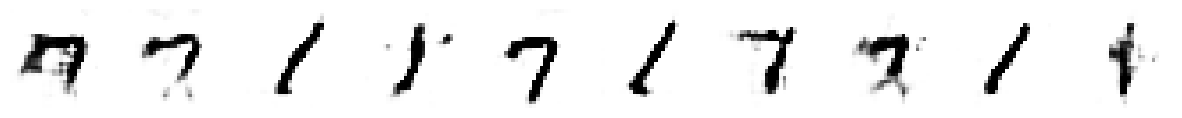

Epoch 30/100, time elapsed: 205.2s, gen_loss: 0.90, dsc_loss: 0.68


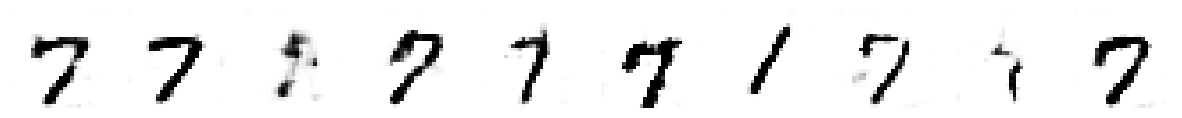

Epoch 40/100, time elapsed: 273.4s, gen_loss: 0.85, dsc_loss: 0.67


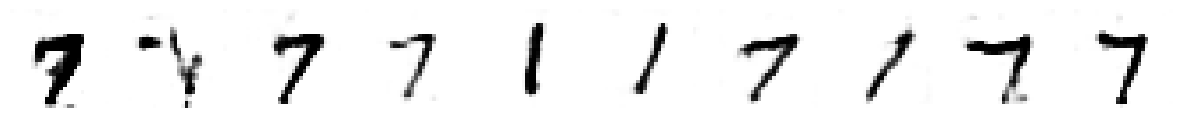

Epoch 50/100, time elapsed: 330.1s, gen_loss: 0.84, dsc_loss: 0.67


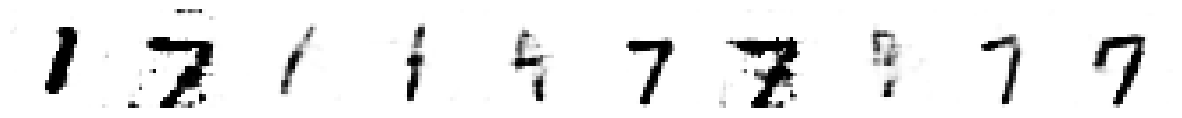

Epoch 60/100, time elapsed: 386.3s, gen_loss: 0.82, dsc_loss: 0.68


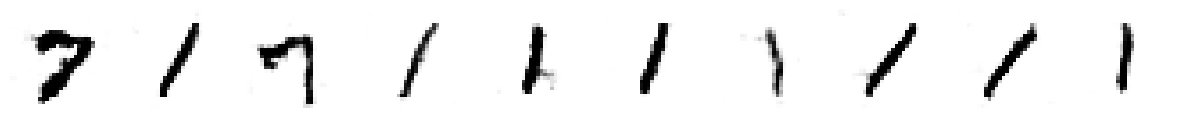

Epoch 70/100, time elapsed: 444.2s, gen_loss: 0.82, dsc_loss: 0.68


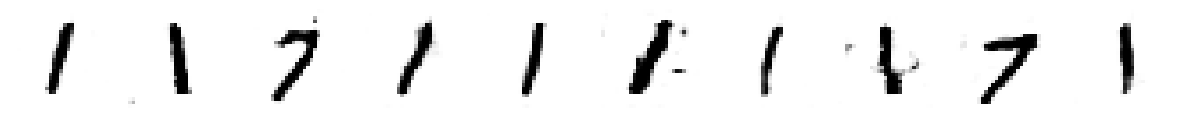

Epoch 80/100, time elapsed: 503.8s, gen_loss: 0.82, dsc_loss: 0.68


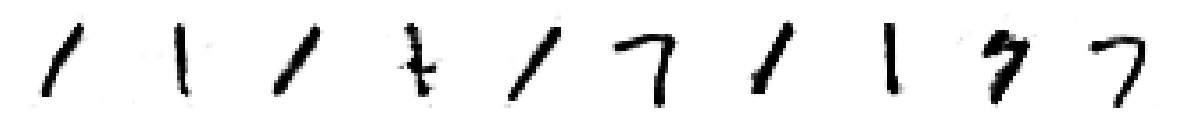

Epoch 90/100, time elapsed: 558.8s, gen_loss: 0.81, dsc_loss: 0.68


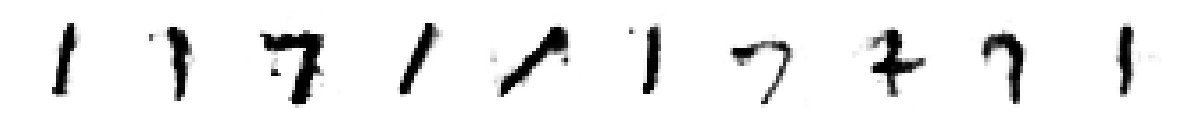

Epoch 100/100, time elapsed: 615.2s, gen_loss: 0.81, dsc_loss: 0.68


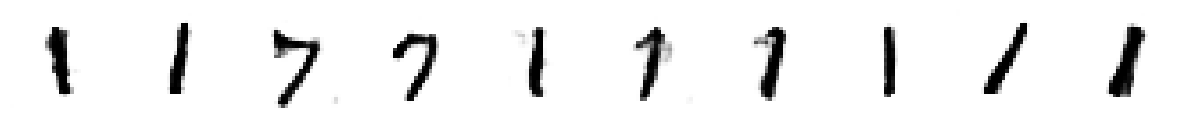

In [ ]:
X_train = load_and_prep_digits("17")
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)
history = train_gan(generator, discriminator, gan, X_train)

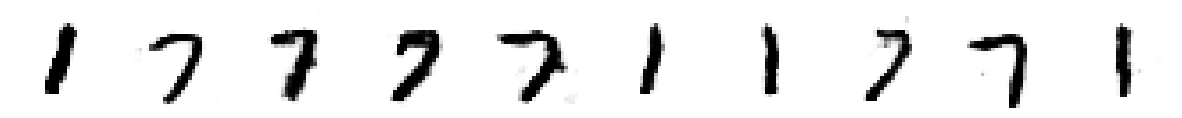

In [ ]:
samples = generate_samples(generator, 10)
plot_samples(samples)

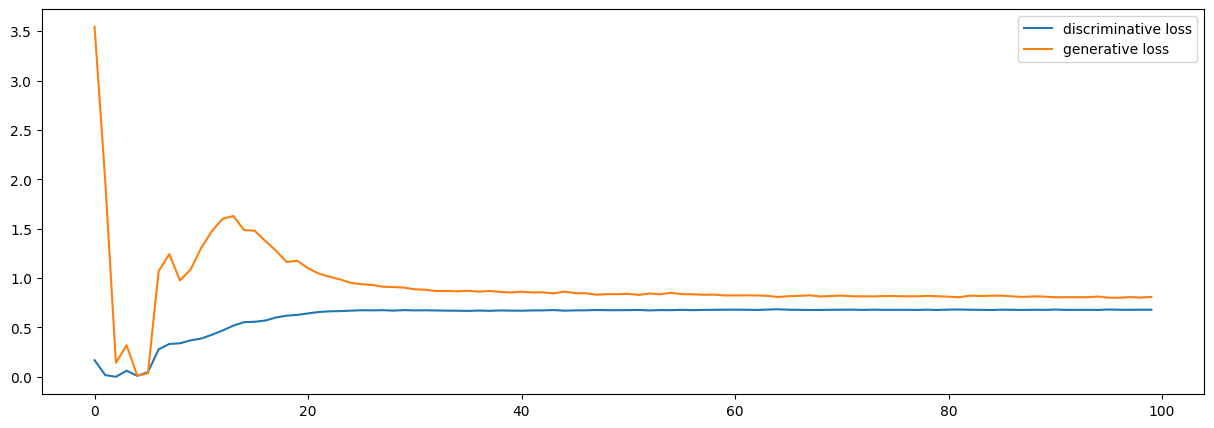

In [ ]:
plot_history(history)

## &#x2766;

# Creating images of fashions

The fashion MNIST dataset, <https://keras.io/api/datasets/fashion_mnist/>, is a dataset of fashion images. It has the same structure as (e.g. image dimensions 28&times;28, 10 categories), and thus can be used as a drop-in replacement for, the MNIST digit dataset.

The following code loads the fashion MNIST dataset, and prints the dimensions and data type of the dataset.

In [12]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
uint8 uint8 uint8 uint8


The 10 fashion categories are shown as follows.

In [13]:
fashion_categories = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

The first 30 images and their categories in the training set are displayed below.

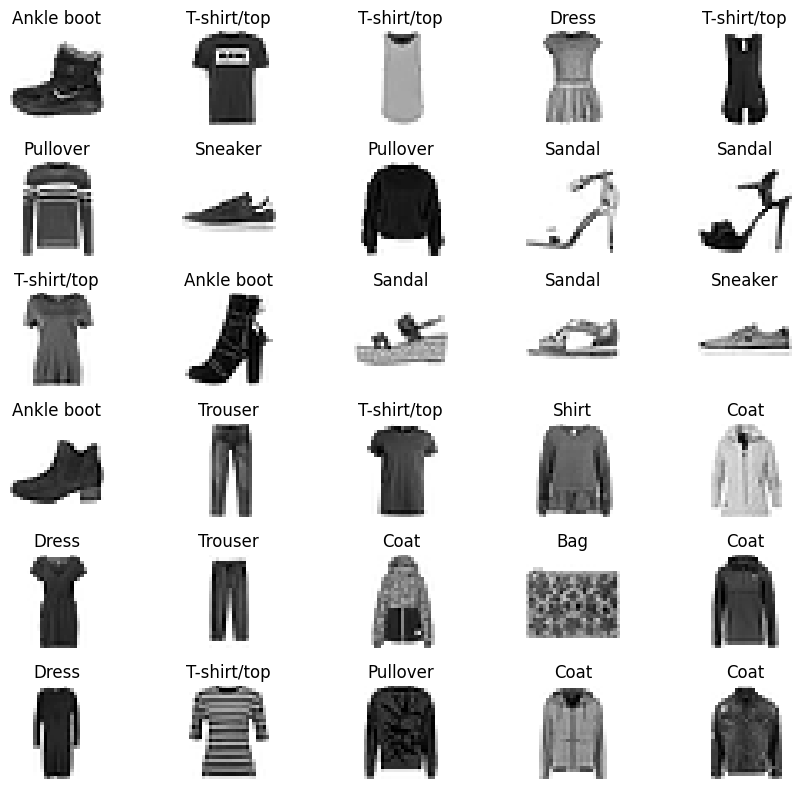

In [14]:
# Display first 30 fashion images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 5, figsize=(10, 8))
for i, ax in enumerate(axs.flat):
    im = ax.imshow(X_train[i], cmap=plt.cm.gray_r)
    ax.set_title(fashion_categories[y_train[i]])
    ax.axis("off")
fig.set_tight_layout("tight")

# Practice - Question 2 of 2

## Q2a

Write a function called `load_and_prep_fashions()` that loads and prepares the fashion MNIST dataset. Refer to the `load_and_prep_digits()` function provided above, and use the `fashion_mnist` module.

In [20]:
def load_and_prep_functions(digits="all", ratio=1.0):#changed function name
    keras.utils.set_random_seed(42)
    (X_train, y_train), _ = fashion_mnist.load_data()
    if digits != "all":
        digits = [int(d) for d in digits]
        mask = np.isin(y_train, digits)
        X_train = X_train[mask]
    if ratio < 1:
        sz_train = int(len(X_train) * ratio)
        X_train = X_train[:sz_train]
    X_train = X_train.astype(float) / 255
    X_train = X_train.reshape(-1, 28, 28, 1)
    return X_train

## Q2b

Build a GAN for creating images of two (or more!) categories of fashions of your choice. Create sample images using the trained GAN, and plot the training history.

Epoch 10/100, time elapsed: 58.0s, gen_loss: 2.60, dsc_loss: 0.45


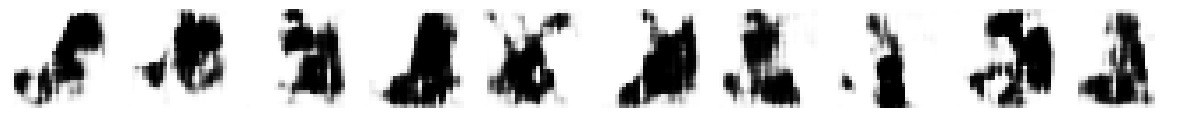

Epoch 20/100, time elapsed: 110.0s, gen_loss: 3.21, dsc_loss: 0.41


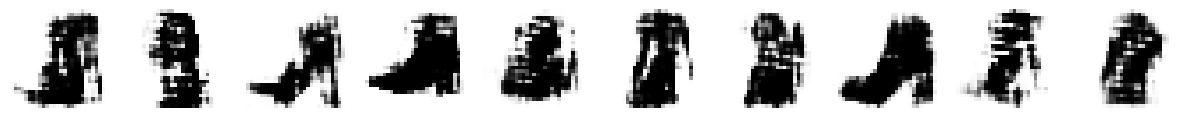

Epoch 30/100, time elapsed: 160.8s, gen_loss: 2.35, dsc_loss: 0.51


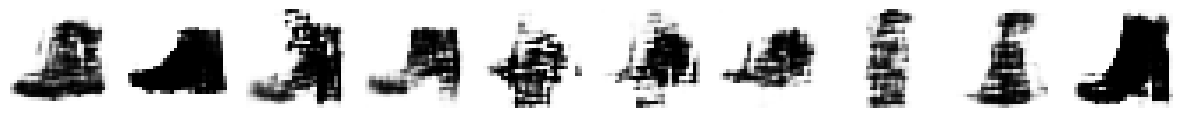

Epoch 40/100, time elapsed: 211.2s, gen_loss: 1.90, dsc_loss: 0.55


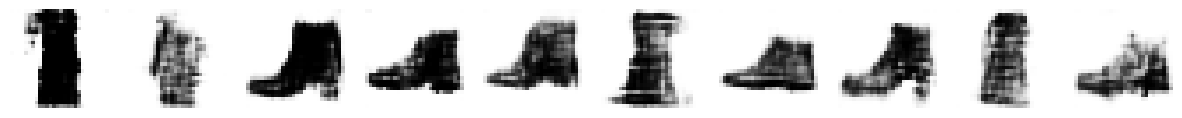

Epoch 50/100, time elapsed: 262.2s, gen_loss: 1.90, dsc_loss: 0.55


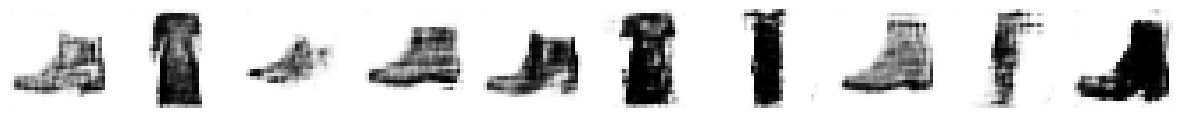

Epoch 60/100, time elapsed: 314.0s, gen_loss: 1.70, dsc_loss: 0.57


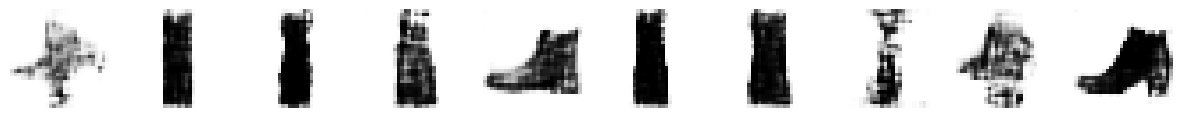

Epoch 70/100, time elapsed: 365.5s, gen_loss: 1.68, dsc_loss: 0.56


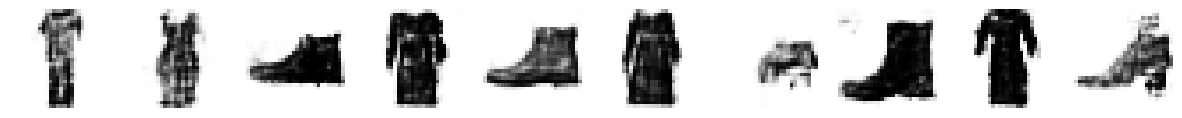

Epoch 80/100, time elapsed: 416.9s, gen_loss: 1.67, dsc_loss: 0.56


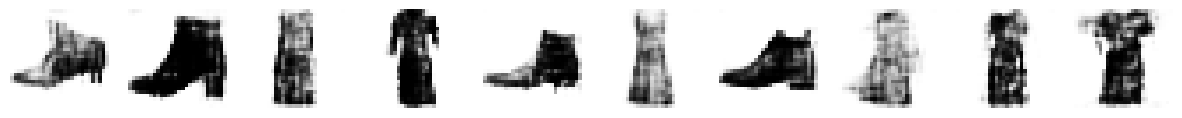

Epoch 90/100, time elapsed: 469.5s, gen_loss: 1.65, dsc_loss: 0.56


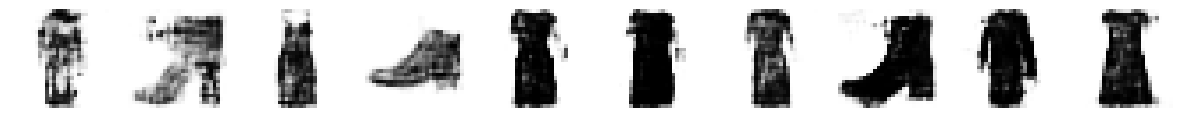

Epoch 100/100, time elapsed: 520.5s, gen_loss: 1.65, dsc_loss: 0.57


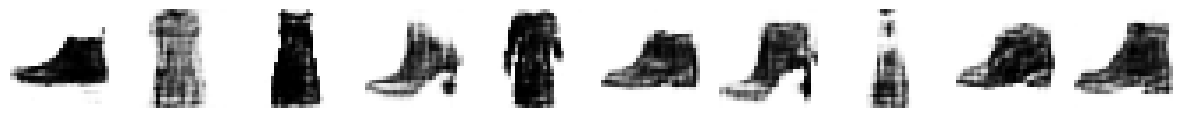

In [21]:
X_train = load_and_prep_functions("39")
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)
history = train_gan(generator, discriminator, gan, X_train)

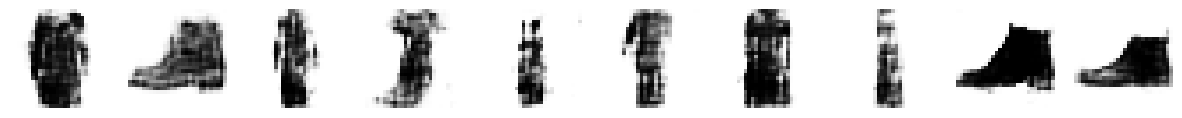

In [22]:
samples = generate_samples(generator, 10)
plot_samples(samples)

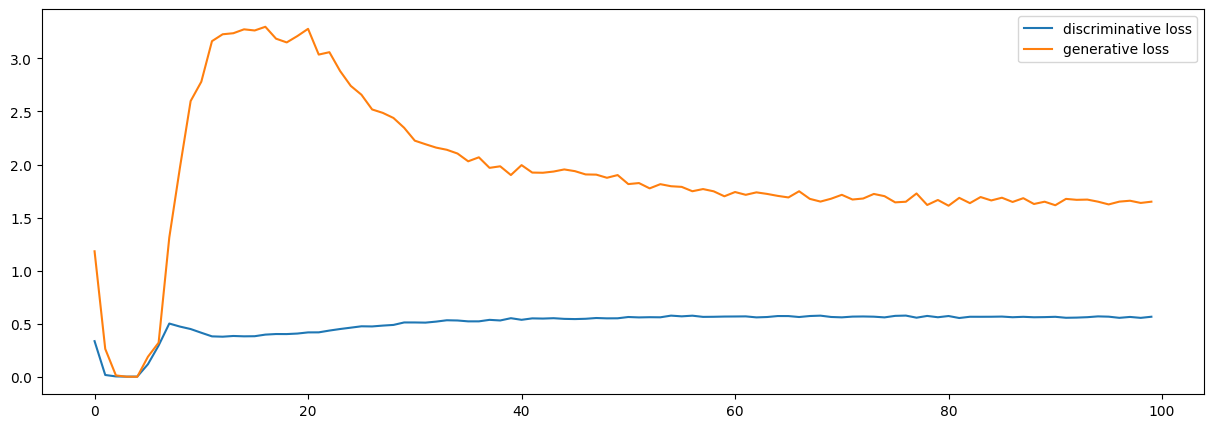

In [23]:
plot_history(history)

## &#x2766;

# Extras

In the above, we adopt the recommended practice of using the leaky ReLU activation in both the discriminator and the generator. In this section, we use the ReLU activation instead and compare the difference.

### E1a

Modify the `create_generator()` and `create_discriminator()` functions to use ReLU instead of leaky ReLU. You may simply redefine the two functions (using the original function names) below so that subsequent code will use the new definitions.

### E1b

Build a GAN for creating images of the "3" digit. Create sample images using the trained GAN, and plot the training history.

### E1c

Compare and comment on the results using ReLU in this section and those using leaky ReLU near the beginning of the lesson.

## Solutions to extra exercises

### E1a

In [ ]:
def create_generator():
    model = keras.Sequential([
        layers.Dense(49),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Reshape(target_shape=(7, 7, 1)),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(64, kernel_size=(5, 5), padding="same"),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(1, kernel_size=(5, 5), padding="same",
                      activation="sigmoid")
    ])
    return model

In [ ]:
def create_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding="same"),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding="same"),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding="same"),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="rmsprop")
    model.trainable = False
    return model

### E1b

Epoch 10/100, time elapsed: 28.7s, gen_loss: 0.00, dsc_loss: 0.00


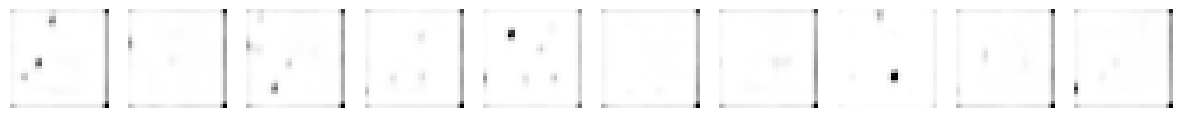

Epoch 20/100, time elapsed: 55.6s, gen_loss: 0.00, dsc_loss: 0.01


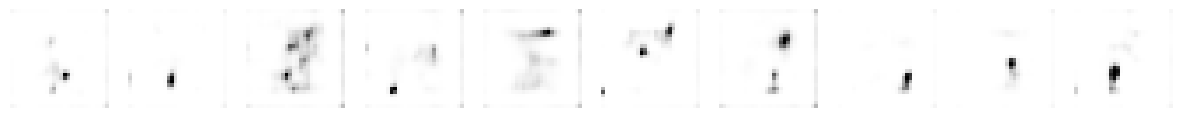

Epoch 30/100, time elapsed: 81.5s, gen_loss: 0.34, dsc_loss: 0.10


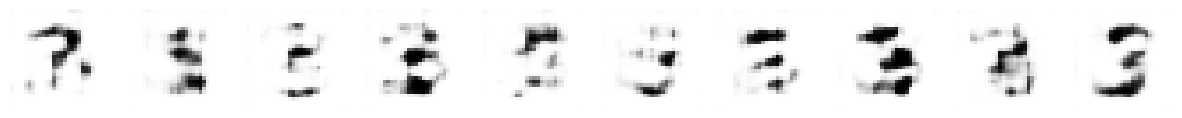

Epoch 40/100, time elapsed: 107.8s, gen_loss: 1.35, dsc_loss: 0.32


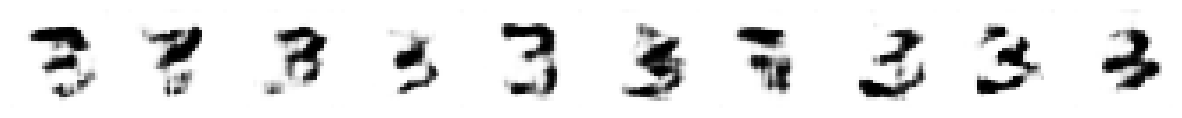

Epoch 50/100, time elapsed: 134.6s, gen_loss: 1.43, dsc_loss: 0.50


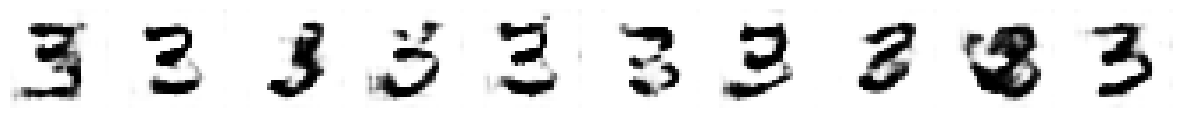

Epoch 60/100, time elapsed: 160.8s, gen_loss: 1.20, dsc_loss: 0.58


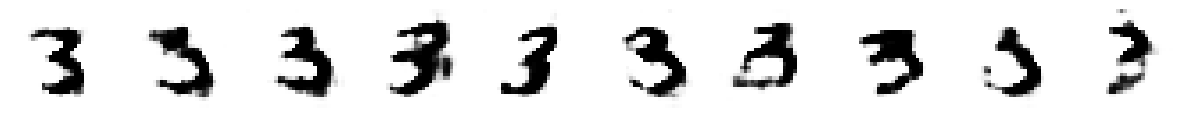

Epoch 70/100, time elapsed: 188.6s, gen_loss: 1.06, dsc_loss: 0.60


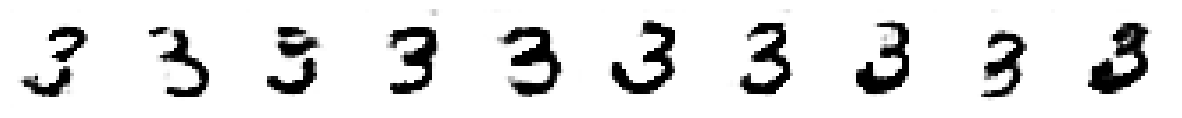

Epoch 80/100, time elapsed: 215.0s, gen_loss: 1.00, dsc_loss: 0.63


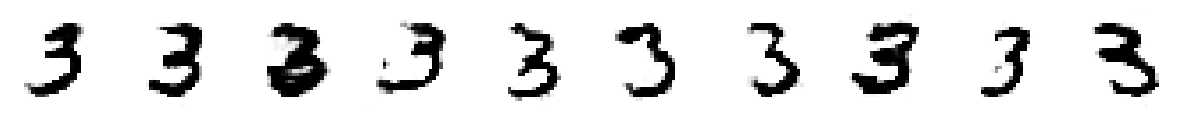

Epoch 90/100, time elapsed: 240.6s, gen_loss: 1.04, dsc_loss: 0.62


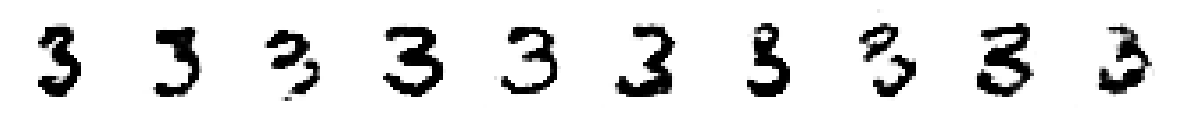

Epoch 100/100, time elapsed: 266.1s, gen_loss: 1.02, dsc_loss: 0.62


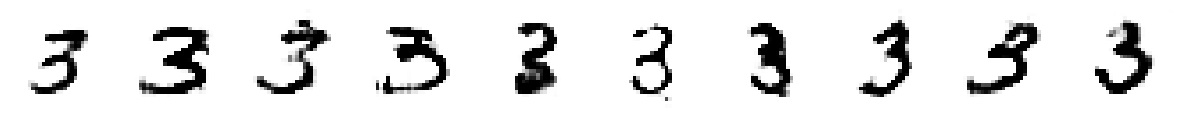

In [ ]:
X_train = load_and_prep_digits("3")
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)
history = train_gan(generator, discriminator, gan, X_train)

Sample images are generated using the trained GAN as follows.

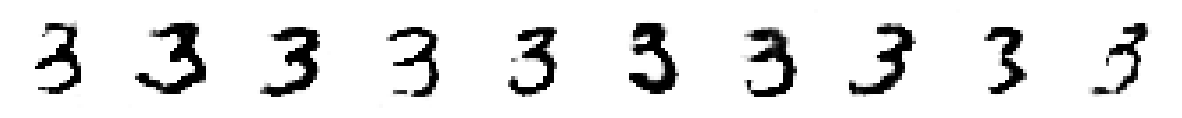

In [ ]:
samples = generate_samples(generator, 10)
plot_samples(samples)

The training history is plotted next.

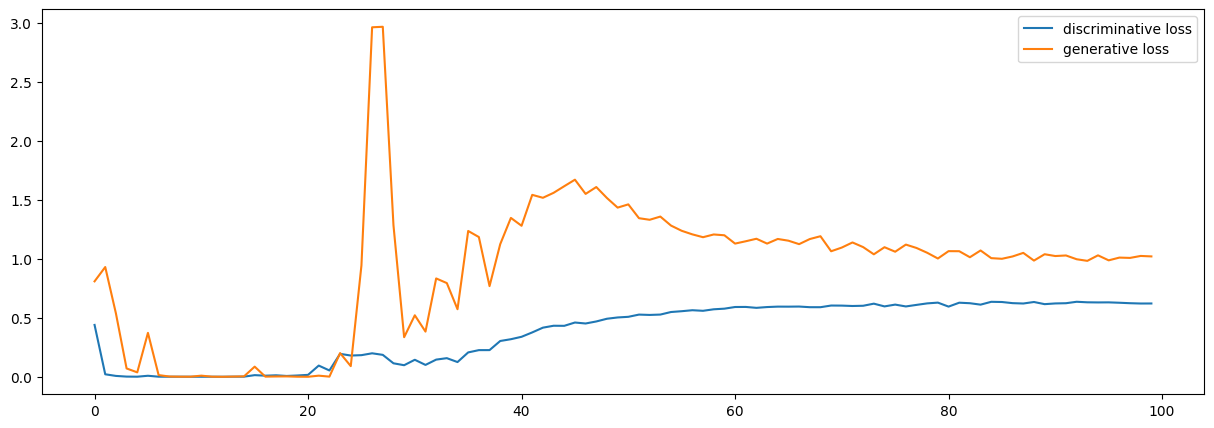

In [ ]:
plot_history(history)

### E1c

There is no observable difference in the quality of the generated images in the two cases. On the other hand, there are some differences in the plots of the training history. Although the overall shapes of the curves are similar, the curves with leaky ReLU is smoother than those with ReLU. In addition, the rising and falling slopes of the curves with leaky ReLU occur to the right of, i.e. earlier than, those with ReLU. This indicates that learning is faster with the leaky ReLU than with ReLU.

## &#x2766;